<a href="https://colab.research.google.com/github/sizhky/Modern-Computer-Vision-with-PyTorch/blob/master/Chapter11/simple_auto_encoder_with_different_latent_size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 102kB 7.0MB/s 


In [ ]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [ ]:
trn_ds = MNIST('/content/', transform=img_transform, train=True, download=True)
val_ds = MNIST('/content/', transform=img_transform, train=False, download=True)

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw




Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
batch_size = 256
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latend_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True), 
            #nn.Linear(64, 12),  nn.ReLU(True), 
            nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(
            #nn.Linear(latent_dim, 12), nn.ReLU(True),
            nn.Linear(latent_dim, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True), 
            nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)
        return x

In [ ]:
!pip install torch_summary
from torchsummary import summary
model = AutoEncoder(3).to(device)
summary(model, torch.zeros(2,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 3]                   195
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 64]                  256
|    └─ReLU: 2-7                         [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 128]                 8,320
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Linear: 2-10                      [-1, 784]                 101,136
|    └─Tanh: 2-11                        [-1, 784]                 

In [ ]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

EPOCH: 1.000	trn_loss: 0.265	val_loss: 0.194	(16.61s - 66.43s remaining)
EPOCH: 2.000	trn_loss: 0.181	val_loss: 0.171	(33.04s - 49.56s remaining)
EPOCH: 3.000	trn_loss: 0.164	val_loss: 0.157	(50.00s - 33.33s remaining)
EPOCH: 4.000	trn_loss: 0.155	val_loss: 0.153	(67.50s - 16.87s remaining)
EPOCH: 5.000	trn_loss: 0.150	val_loss: 0.148	(84.35s - 0.00s remaining)


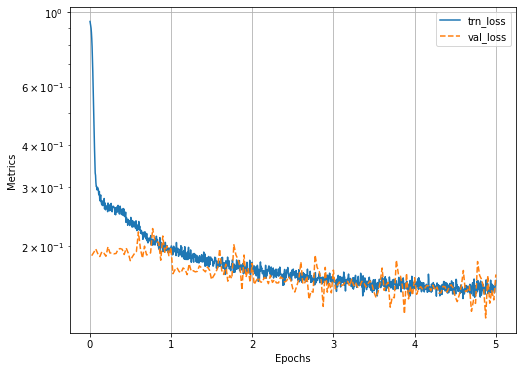

In [ ]:
model = AutoEncoder(3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 5
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
    log.report_avgs(epoch+1)
log.plot(log=True)

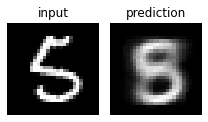

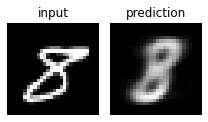

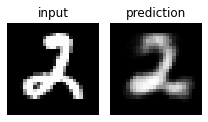

In [ ]:
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1,2,figsize=(3,3)) 
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

EPOCH: 1.000	trn_loss: 0.230	val_loss: 0.134	(16.78s - 67.12s remaining)
EPOCH: 2.000	trn_loss: 0.113	val_loss: 0.095	(33.82s - 50.73s remaining)
EPOCH: 3.000	trn_loss: 0.089	val_loss: 0.081	(50.78s - 33.85s remaining)
EPOCH: 4.000	trn_loss: 0.077	val_loss: 0.071	(67.58s - 16.89s remaining)
EPOCH: 5.000	trn_loss: 0.070	val_loss: 0.066	(84.37s - 0.00s remaining)


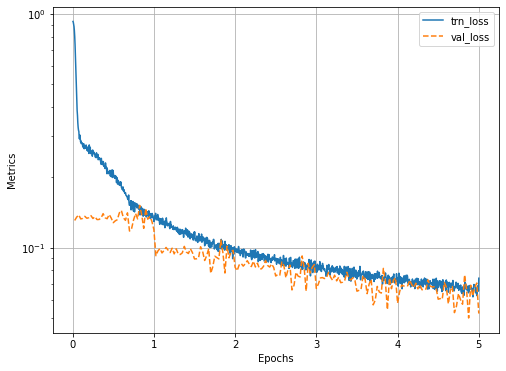

EPOCH: 1.000	trn_loss: 0.257	val_loss: 0.206	(17.51s - 70.05s remaining)
EPOCH: 2.000	trn_loss: 0.197	val_loss: 0.190	(34.79s - 52.18s remaining)
EPOCH: 3.000	trn_loss: 0.186	val_loss: 0.182	(52.41s - 34.94s remaining)
EPOCH: 4.000	trn_loss: 0.180	val_loss: 0.178	(69.60s - 17.40s remaining)
EPOCH: 5.000	trn_loss: 0.176	val_loss: 0.174	(86.33s - 0.00s remaining)


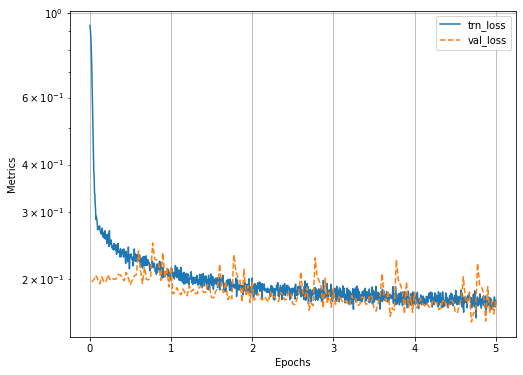

EPOCH: 1.000	trn_loss: 0.258	val_loss: 0.195	(16.43s - 65.74s remaining)
EPOCH: 2.000	trn_loss: 0.181	val_loss: 0.170	(33.44s - 50.16s remaining)
EPOCH: 3.000	trn_loss: 0.164	val_loss: 0.159	(50.44s - 33.63s remaining)
EPOCH: 4.000	trn_loss: 0.156	val_loss: 0.153	(67.33s - 16.83s remaining)
EPOCH: 5.000	trn_loss: 0.151	val_loss: 0.149	(84.36s - 0.00s remaining)


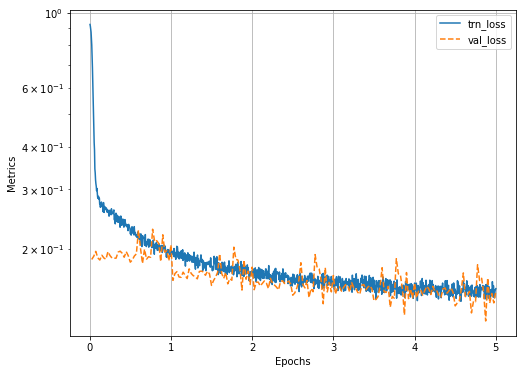

EPOCH: 1.000	trn_loss: 0.248	val_loss: 0.167	(17.22s - 68.86s remaining)
EPOCH: 2.000	trn_loss: 0.151	val_loss: 0.140	(34.76s - 52.15s remaining)
EPOCH: 3.000	trn_loss: 0.134	val_loss: 0.128	(50.99s - 33.99s remaining)
EPOCH: 4.000	trn_loss: 0.126	val_loss: 0.123	(67.91s - 16.98s remaining)
EPOCH: 5.000	trn_loss: 0.121	val_loss: 0.119	(85.34s - 0.00s remaining)


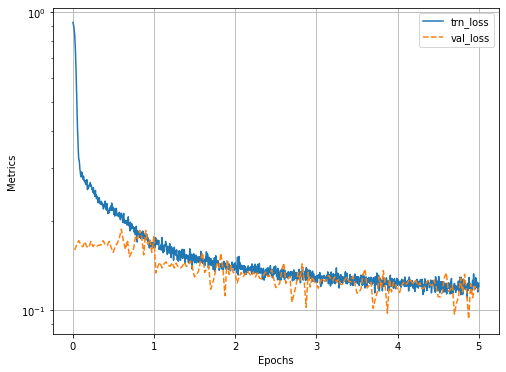

EPOCH: 1.000	trn_loss: 0.240	val_loss: 0.146	(17.07s - 68.27s remaining)
EPOCH: 2.000	trn_loss: 0.128	val_loss: 0.113	(34.19s - 51.28s remaining)
EPOCH: 3.000	trn_loss: 0.109	val_loss: 0.103	(51.37s - 34.24s remaining)
EPOCH: 4.000	trn_loss: 0.101	val_loss: 0.095	(68.20s - 17.05s remaining)
EPOCH: 5.000	trn_loss: 0.095	val_loss: 0.091	(85.43s - 0.00s remaining)


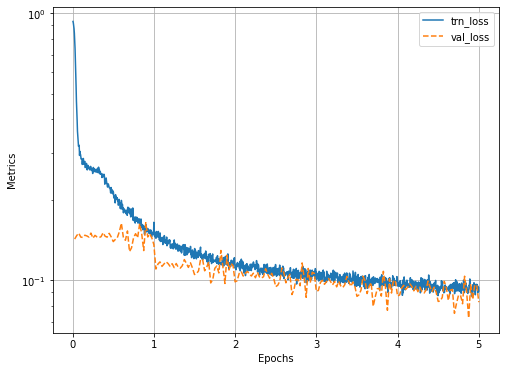

In [ ]:
def train_aec(latent_dim):
    model = AutoEncoder(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

    num_epochs = 5
    log = Report(num_epochs)

    for epoch in range(num_epochs):
        N = len(trn_dl)
        for ix, (data, _) in enumerate(trn_dl):
            loss = train_batch(data, model, criterion, optimizer)
            log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

        N = len(val_dl)
        for ix, (data, _) in enumerate(val_dl):
            loss = validate_batch(data, model, criterion)
            log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
        log.report_avgs(epoch+1)
    log.plot(log=True)
    return model

aecs = [train_aec(dim) for dim in [50, 2, 3, 5, 10]]

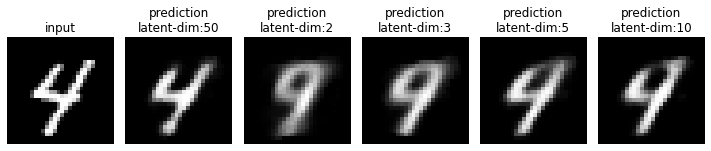

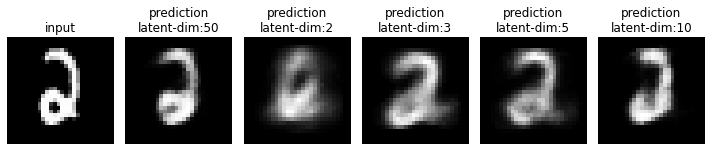

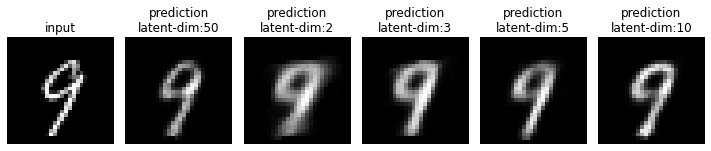

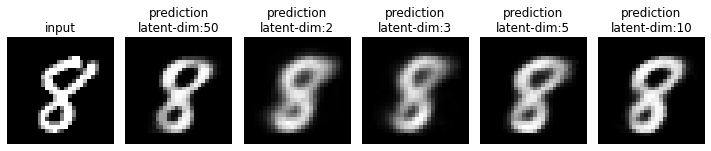

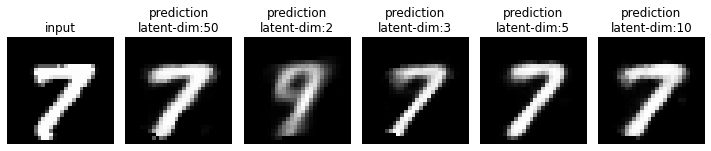

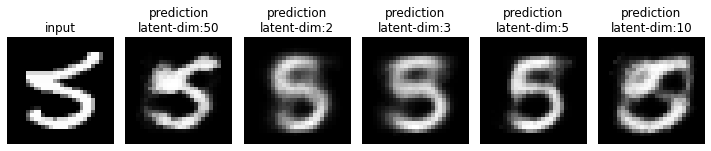

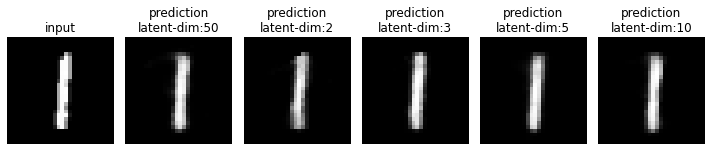

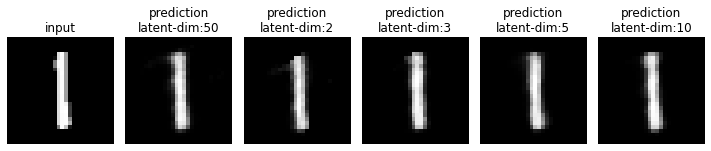

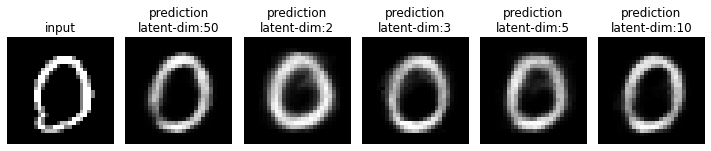

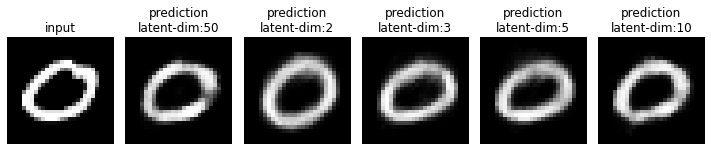

In [ ]:
for _ in range(10):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    fig, ax = plt.subplots(1, len(aecs)+1, figsize=(10,4))
    ax = iter(ax.flat)
    show(im[0], ax=next(ax), title='input')
    for model in aecs:
        _im = model(im[None])[0]
        show(_im[0], ax=next(ax), title=f'prediction\nlatent-dim:{model.latend_dim}')
    plt.tight_layout()
    plt.show()